### step5 Function

In [3]:
import numpy as np

class Variable:
  def __init__(self, data):
    self.data = data

class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    self.input = input
    self.output = output
    return output

  def backward(self, x):
    raise NotImplementedError()

class Square(Function):
  def forward(self, x):
    return x ** 2

class Exp(Function):
  def forward(self, x):
    return np.exp(x)

# 微分法求导
def numerical_diff(f: Function, x: Variable, eps=1e-4):
  x0 = Variable(x.data - eps)
  x1 = Variable(x.data + eps)
  y0 = f(x0)
  y1 = f(x1)
  return (y1.data - y0.data) / (2 * eps)

In [4]:
f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
dy

4.000000000004

In [5]:
def f(x):
  A = Square()
  B = Exp()
  C = Square()
  return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
dy

3.2974426293330694

### step6 backward

In [13]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    
class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    self.input = input
    self.output = output
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()

class Square(Function):
  def forward(self, x):
    return x ** 2

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx
  
class Exp(Function):
  def forward(self, x):
    return np.exp(x)
  
  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

In [14]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)
y.data

1.648721270700128

In [12]:
import math as math
(math.exp(0.5 ** 2) ** 2)

1.648721270700128

In [15]:
y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
x.grad

3.297442541400256

### step7 creator

In [24]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func: Function):
    self.creator = func

  def backward(self):
    f = self.creator
    if f is not None:
      x = f.input
      x.grad = f.backward(self.grad)
      x.backward()

class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    output.set_creator(self)
    self.input = input
    self.output = output
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()
  
class Square(Function):
  def forward(self, x):
    return x ** 2

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx
  
class Exp(Function):
  def forward(self, x):
    return np.exp(x)
  
  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

In [25]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()

print(x.grad)

3.297442541400256


### step8 

In [26]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func: Function):
    self.creator = func

  def backward(self):
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)
    
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()

print(x.grad)

3.297442541400256


### step9

In [27]:
def square(x):
  return Square()(x)

def exp(x):
  return Exp()(x)

x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


In [29]:
def as_array(x):
  if np.isscalar(x):
    return np.array(x)
  return x

class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError(f'{type(data)} is not supported')
      
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func: Function):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(as_array(y))
    output.set_creator(self)
    self.input = input
    self.output = output
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()
  
class Square(Function):
  def forward(self, x):
    return x ** 2

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx
  
class Exp(Function):
  def forward(self, x):
    return np.exp(x)
  
  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

def square(x):
  return Square()(x)

def exp(x):
  return Exp()(x)

x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


### step27 my_sin

In [2]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

In [4]:
import numpy as np
import math
from grad import Variable, Function
from grad.utils import plot_dot_graph

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = gy * np.cos(x)
    return gx
  
def sin(x):
  return Sin()(x)

x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
0.7071067811865476


In [5]:
def my_sin(x, threshold=0.0001):
  y = 0
  for i in range(100000):
    c = (-1) ** i / math.factorial(2 * i + 1)
    t = c * x ** (2 * i + 1)
    y = y + t
    if abs(t.data) < threshold:
      break
  return y

x = Variable(np.array(np.pi/4))
y = my_sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071064695751781
0.7071032148228457


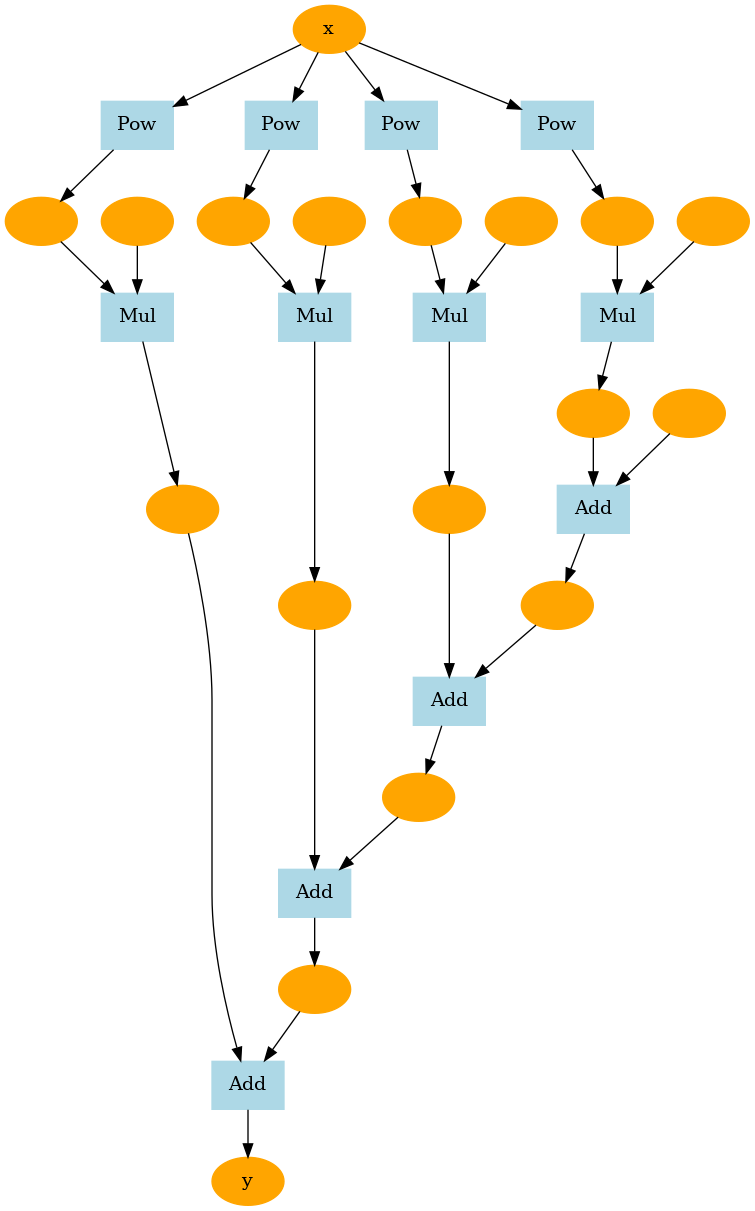

In [6]:
x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin.png')

### step33 

In [2]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

import numpy as np
from grad import Variable, Function

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward(create_graph=True)
  # 一阶导数 梯度
  gx = x.grad
  x.cleargrad()
  gx.backward()
  # 二阶导数 梯度
  gx2 = x.grad
  # 牛顿法
  x.data -= gx.data / gx2.data
    

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)
